In [4]:
import pandas as pd 
train=pd.read_csv('train.csv')   #Reads csv file
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [5]:
train=train.drop(columns=['Loan_ID'])     #Drops column Loan_ID

categorical_columns=['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Credit_History','Loan_Amount_Term']
print(categorical_columns)

numerical_columns=['ApplicantIncome','CoapplicantIncome','LoanAmount']
print(numerical_columns)

['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Credit_History', 'Loan_Amount_Term']
['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']


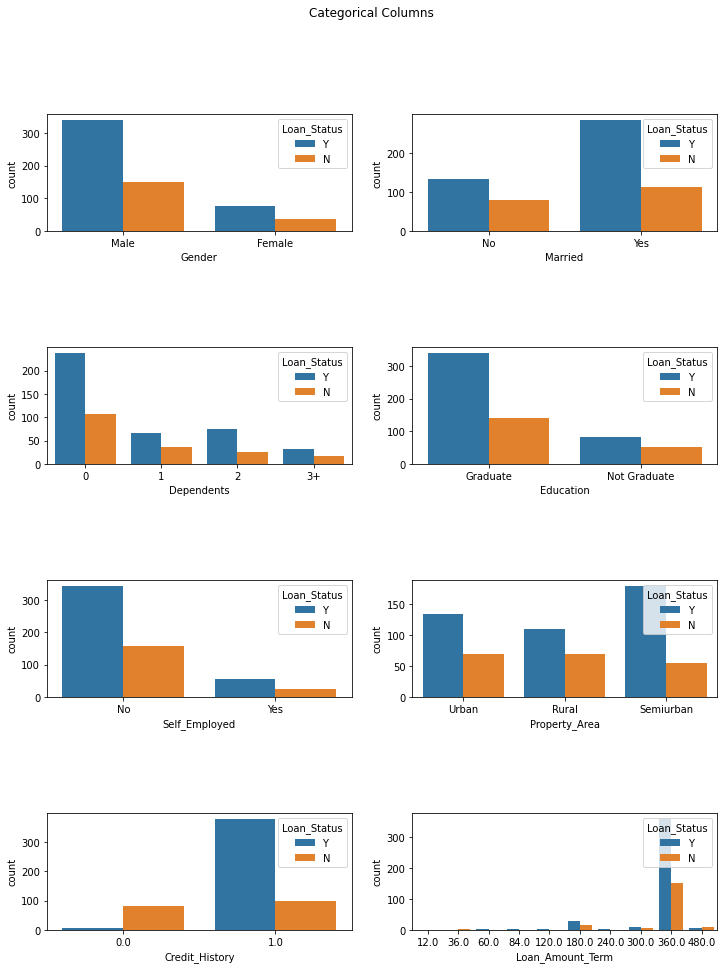

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,axes=plt.subplots(4,2,figsize=(12,15))     #figsize set the total dimension of the figure & 4 rows-2 columns
fig.suptitle('Categorical Columns')
for idx,cat_col in enumerate(categorical_columns):
    row,col=idx//2,idx%2
    sns.countplot(x=cat_col,data=train,hue='Loan_Status',ax=axes[row,col])
    
plt.subplots_adjust(hspace=1)    #hspace is vertical space between two rows of graphs 

       ApplicantIncome  CoapplicantIncome  LoanAmount
count       614.000000         614.000000  592.000000
mean       5403.459283        1621.245798  146.412162
std        6109.041673        2926.248369   85.587325
min         150.000000           0.000000    9.000000
25%        2877.500000           0.000000  100.000000
50%        3812.500000        1188.500000  128.000000
75%        5795.000000        2297.250000  168.000000
max       81000.000000       41667.000000  700.000000


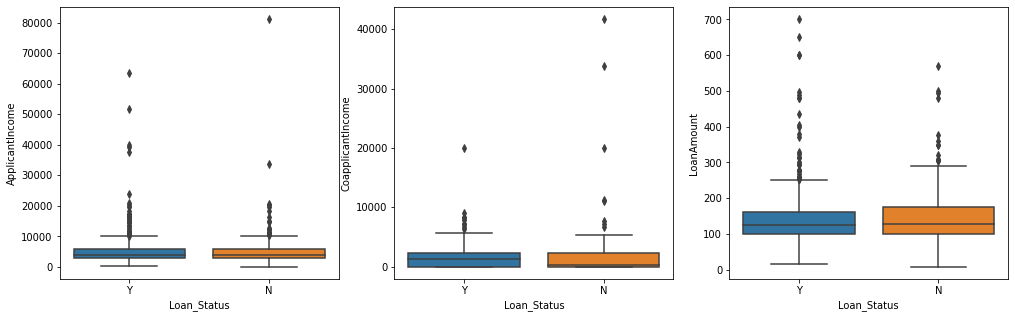

In [7]:
fig,axes=plt.subplots(1,3,figsize=(17,5))

for idx,cat_col in enumerate(numerical_columns):
    sns.boxplot(y=cat_col,data=train,x='Loan_Status',ax=axes[idx])
    
print(train[numerical_columns].describe())    #Describes the numerical columns
plt.subplots_adjust(hspace=1)   

In [8]:
#Encoding categorical features
train_encoded=pd.get_dummies(train,drop_first=True)
train_encoded.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,5849,0.0,NaN,360.0,1.0,1,0,0,0,0,0,0,0,1,1
1,4583,1508.0,128.0,360.0,1.0,1,1,1,0,0,0,0,0,0,0
2,3000,0.0,66.0,360.0,1.0,1,1,0,0,0,0,1,0,1,1
3,2583,2358.0,120.0,360.0,1.0,1,1,0,0,0,1,0,0,1,1
4,6000,0.0,141.0,360.0,1.0,1,0,0,0,0,0,0,0,1,1


In [9]:
#Split Features and Target Varible
X = train_encoded.drop(columns='Loan_Status_Y')
y = train_encoded['Loan_Status_Y']

#Splitting into Train-Test Data
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify =y,random_state =42)

#Handling/Imputing Missing values
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='mean')   #Imputation to fill the missing values. Mean of column will be replaced
imp_train = imp.fit(X_train)
X_train = imp_train.transform(X_train)
X_test_imp = imp_train.transform(X_test)

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import accuracy_score,f1_score

tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_train)

print("Training Data Set Accuracy: ", accuracy_score(y_train,y_pred))  #(correct_labels,predicted_labels)
#Balanced F-score(Avg of score of each class)
print("Training Data F1 Score ", f1_score(y_train,y_pred))             #(correct_labels,estimated_targets)

#Evaluate a score by cross-validation
print("Validation Mean F1 Score: ",cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean())

Training Data Set Accuracy:  1.0
Training Data F1 Score  1.0
Validation Mean F1 Score:  0.65442094468015
Validation Mean Accuracy:  0.7066996495567924


Training accuracy> Test accuracy with default seetings of decision tree classifier so model is overfit.

<AxesSubplot:xlabel='Decision Threshold', ylabel='Values'>

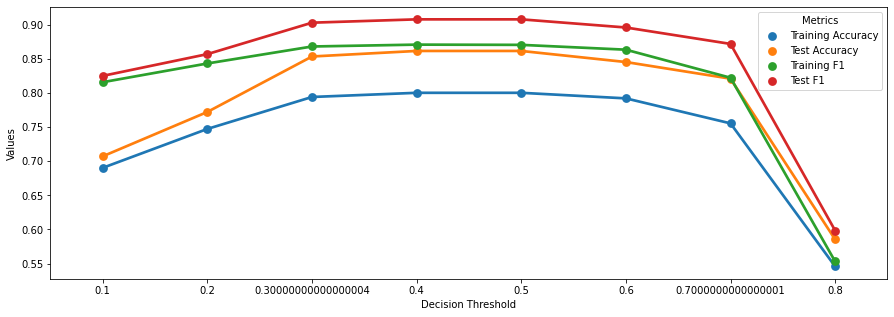

In [11]:
from sklearn.linear_model import LogisticRegression
import numpy as np

train_accuracies = []
train_f1_scores = []
test_accuracies = []
test_f1_scores = []
thresholds = []

#for thresh in np.linspace(0.1,0.9,8): ## Sweeping from threshold of 0.1 to 0.9
for thresh in np.arange(0.1,0.9,0.1): ## Sweeping from threshold of 0.1 to 0.9
    logreg_clf = LogisticRegression(solver='liblinear')
    logreg_clf.fit(X_train,y_train)
    
    y_pred_train_thresh = logreg_clf.predict_proba(X_train)[:,1]
    y_pred_train = (y_pred_train_thresh > thresh).astype(int)

    train_acc = accuracy_score(y_train,y_pred_train)
    train_f1 = f1_score(y_train,y_pred_train)
    
    y_pred_test_thresh = logreg_clf.predict_proba(X_test_imp)[:,1]
    y_pred_test = (y_pred_test_thresh > thresh).astype(int) 
    
    test_acc = accuracy_score(y_test,y_pred_test)
    test_f1 = f1_score(y_test,y_pred_test)
    
    train_accuracies.append(train_acc)
    train_f1_scores.append(train_f1)
    test_accuracies.append(test_acc)
    test_f1_scores.append(test_f1)
    thresholds.append(thresh)
    
    
Threshold_logreg = {"Training Accuracy": train_accuracies, "Test Accuracy": test_accuracies, "Training F1": train_f1_scores, "Test F1":test_f1_scores, "Decision Threshold": thresholds }
Threshold_logreg_df = pd.DataFrame.from_dict(Threshold_logreg)

plot_df = Threshold_logreg_df.melt('Decision Threshold',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Decision Threshold", y="Values",hue="Metrics", data=plot_df,ax=ax)

In [12]:
thresh = 0.4 #Threshold chosen from above Curves
y_pred_test_thresh = logreg_clf.predict_proba(X_test_imp)[:,1]
y_pred = (y_pred_test_thresh > thresh).astype(int) 

print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")

pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.8617886178861789
Test F1 Score:  0.9081081081081082
Confusion Matrix on Test Data


Predicted,0,1,All
True,,,
0,22,16,38
1,1,84,85
All,23,100,123
